This is notebook is in beta, expect bugs and missing features compared to other ZeroCostDL4Mic notebooks

- Training now uses TORCH. 
- Currently missing features include:  
  - The training and validation curves are not saved or visualised
  

# **Cellpose - Omnipose (2D)**

---



<font size = 4>**Cellpose 2D** is a deep-learning method that can be used to segment cell and/or nuclei from bioimages and was first published by [Stringer *et al.* in 2020, in Nature Method](https://www.nature.com/articles/s41592-020-01018-x). Omnipose was developped by [Kevin John Cutler and colleagues](https://www.biorxiv.org/content/10.1101/2021.11.03.467199v2).

<font size = 4> **This particular notebook enables segmentation of 2D and 3D datasets. Hovewer, training is limited to 2D images. If you are interested in using 3D datasets for training, you should use the StarDist or U-Net 3D notebooks instead.**

---
<font size = 4>*Disclaimer*:

<font size = 4>This notebook is part of the Zero-Cost Deep-Learning to Enhance Microscopy project (https://github.com/HenriquesLab/DeepLearning_Collab/wiki). Jointly developed by the Jacquemet (link to https://cellmig.org/) and Henriques (https://henriqueslab.github.io/) laboratories.

<font size = 4>This notebook is largely based on the paper:

<font size = 4>**Cellpose: a generalist algorithm for cellular segmentation** from Stringer *et al.*, Nature Methods, 2020. (https://www.nature.com/articles/s41592-020-01018-x)

<font size = 4>**Omnipose: a high-precision morphology-independent solution for bacterial cell segmentation** from Kevin J. Cutler et al, biorXiv, 2021. (https://www.biorxiv.org/content/10.1101/2021.11.03.467199v2)

<font size = 4>**The Original code** is freely available in GitHub:
https://github.com/MouseLand/cellpose

<font size = 4>**Please also cite these original papers when using or developing this notebook.**

<font size = 4>**This notebook was also inspired by the one created by  @pr4deepr** which is available here:
https://colab.research.google.com/github/MouseLand/cellpose/blob/master/notebooks/Cellpose_2D_v0_1.ipynb


#**0. Before getting started**
---
<font size = 4> For Cellpose to train, **it needs to have access to a paired training dataset made of images and their corresponding masks (label images)**. Information on how to generate a training dataset is available in our Wiki page: https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki

<font size = 4>**We strongly recommend that you generate extra paired images. These images can be used to assess the quality of your trained model**. The quality control assessment can be done directly in this notebook.

<font size = 4>The data structure is important. It is necessary that all the input data are in the same folder and that all the output data is in a separate folder. The provided training dataset is already split in two folders called "Training - Images" (Training_source) and "Training - Masks" (Training_target).

<font size = 4>Additionally, the corresponding Training_source and Training_target files need to have **the same name**.

<font size = 4> **Use 8/16 bit png or Tiff images**.


<font size = 4>You can also provide a folder that contains the data that you wish to analyse with the trained network once all training has been performed. This can include Test dataset for which you have the equivalent output and can compare to what the network provides.

<font size = 4>Here's a common data structure that can work:
*   Experiment A
    - **Training dataset**
      - Images (Training_source)
        - img_1.tif, img_2.tif, ...
      - Label images (Training_target)
        - img_1.tif, img_2.tif, ...
    - **Quality control dataset**
     - Images
        - img_1.tif, img_2.tif
      - Masks 
        - img_1.tif, img_2.tif
    - **Data to be predicted**
    - **Results**

---
<font size = 4>**Important note**

<font size = 4>- If you wish to **Train a network from scratch** using your own dataset (and we encourage everyone to do that), you will need to run **sections 1 - 4**, then use **section 5** to assess the quality of your model and **section 6** to run predictions using the model that you trained.

<font size = 4>- If you wish to **Evaluate your model** using a model previously generated and saved on your Google Drive, you will only need to run **sections 1 and 2** to set up the notebook, then use **section 5** to assess the quality of your model.

<font size = 4>- If you only wish to **run predictions** using a pretrained model you will only need to run **sections 1 and 2** to set up the notebook, then use **section 6** to run the predictions on the desired model.
---

# **1. Install Cellpose and dependencies**
---


In [ ]:

#@markdown ##Install Cellpose 

#Libraries contains information of certain topics. 
#For example the tifffile library contains information on how to handle tif-files.

#Here, we install libraries which are not already included in Colab.

!pip uninstall -y -q yellowbrick

!pip install -q tifffile # contains tools to operate tiff-files
!pip install -q folium==0.2.1
!pip install -q imgaug==0.2.5
#!pip install -q opencv-python==3.4.5.20
!pip install -q opencv-python-headless==4.1.2.30
#!pip install -q numpy==1.20.0
!pip install -q cellpose==1.0.2
!pip install -q wget
!pip install -q memory_profiler
!pip install -q fpdf

#Force session restart
exit(0)




## **1.2. Restart your runtime**
---
<font size = 4>


**<font size = 4> Ignore the following message error message. Your Runtime has automatically restarted. This is normal.**

<img width="40%" alt ="" src="https://github.com/HenriquesLab/ZeroCostDL4Mic/raw/master/Wiki_files/session_crash.png"><figcaption>  </figcaption>






## **1.3. Load key dependencies**
---
<font size = 4> 

In [ ]:
#@markdown ##Load key dependencies

Notebook_version = '1.15.3'
Network = 'Cellpose'

from builtins import any as b_any

%load_ext memory_profiler

def get_requirements_path():
    # Store requirements file in 'contents' directory
    current_dir = os.getcwd()
    dir_count = current_dir.count('/') - 1
    path = '../' * (dir_count) + 'requirements.txt'
    return path

def filter_files(file_list, filter_list):
    filtered_list = []
    for fname in file_list:
        if b_any(fname.split('==')[0] in s for s in filter_list):
            filtered_list.append(fname)
    return filtered_list

def build_requirements_file(before, after):
    path = get_requirements_path()

    # Exporting requirements.txt for local run
    !pip freeze > $path

    # Get minimum requirements file
    df = pd.read_csv(path, delimiter = "\n")
    mod_list = [m.split('.')[0] for m in after if not m in before]
    req_list_temp = df.values.tolist()
    req_list = [x[0] for x in req_list_temp]

    # Replace with package name and handle cases where import name is different to module name
    mod_name_list = [['sklearn', 'scikit-learn'], ['skimage', 'scikit-image']]
    mod_replace_list = [[x[1] for x in mod_name_list] if s in [x[0] for x in mod_name_list] else s for s in mod_list]
    filtered_list = filter_files(req_list, mod_replace_list)

    file=open(path,'w')
    for item in filtered_list:
        file.writelines(item + '\n')

    file.close()

import sys
before = [str(m) for m in sys.modules]



# ------- Variable specific to Cellpose -------

from urllib.parse import urlparse
%matplotlib inline
from cellpose import models
#use_GPU = models.use_gpu()

#import mxnet as mx

from skimage.util import img_as_ubyte
import cv2
from cellpose import plot
from ipywidgets import interact, interact_manual
from zipfile import ZIP_DEFLATED


# For sliders and dropdown menu and progress bar
from ipywidgets import interact
import ipywidgets as widgets


# ------- Common variable to all ZeroCostDL4Mic notebooks -------
import numpy as np
from matplotlib import pyplot as plt
import urllib
import os, random
import shutil 
import zipfile
from tifffile import imread, imsave
import time
import sys
import wget
from pathlib import Path
import pandas as pd
import csv
from glob import glob
from scipy import signal
from scipy import ndimage
from skimage import io
from sklearn.linear_model import LinearRegression
from skimage.util import img_as_uint
import matplotlib as mpl
from skimage.metrics import structural_similarity
from skimage.metrics import peak_signal_noise_ratio as psnr
from astropy.visualization import simple_norm
from skimage import img_as_float32
from skimage.util import img_as_ubyte
from tqdm import tqdm 
from fpdf import FPDF, HTMLMixin
from datetime import datetime
import subprocess
from pip._internal.operations.freeze import freeze

# Colors for the warning messages
class bcolors:
  WARNING = '\033[31m'

W  = '\033[0m'  # white (normal)
R  = '\033[31m' # red

#Disable some of the tensorflow warnings
import warnings
warnings.filterwarnings("ignore")

print("Libraries installed")

# Check if this is the latest version of the notebook
All_notebook_versions = pd.read_csv("https://raw.githubusercontent.com/HenriquesLab/ZeroCostDL4Mic/master/Colab_notebooks/Latest_Notebook_versions.csv", dtype=str)
print('Notebook version: '+Notebook_version)
Latest_Notebook_version = All_notebook_versions[All_notebook_versions["Notebook"] == Network]['Version'].iloc[0]
print('Latest notebook version: '+Latest_Notebook_version)
if Notebook_version == Latest_Notebook_version:
  print("This notebook is up-to-date.")
else:
  print(bcolors.WARNING +"A new version of this notebook has been released. We recommend that you download it at https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki")


!pip freeze > requirements.txt

#Create a pdf document with training summary

def pdf_export(trained = False, augmentation = False, pretrained_model = False):
    # save FPDF() class into a  
    # variable pdf 
    #from datetime import datetime

    class MyFPDF(FPDF, HTMLMixin):
        pass

    pdf = MyFPDF()
    pdf.add_page()
    pdf.set_right_margin(-1)
    pdf.set_font("Arial", size = 11, style='B') 

    
    day = datetime.now()
    datetime_str = str(day)[0:10]

    Header = 'Training report for '+Network+' model ('+model_name+')\nDate: '+datetime_str
    pdf.multi_cell(180, 5, txt = Header, align = 'L') 

    # add another cell 
    if trained:
      training_time = "Training time: "+str(hour)+ "hour(s) "+str(mins)+"min(s) "+str(round(sec))+"sec(s)"
      pdf.cell(190, 5, txt = training_time, ln = 1, align='L')
    pdf.ln(1)

    Header_2 = 'Information for your materials and methods:'
    pdf.cell(190, 5, txt=Header_2, ln=1, align='L')

    all_packages = ''
    for requirement in freeze(local_only=True):
      all_packages = all_packages+requirement+', '
    #print(all_packages)

    #Main Packages
    main_packages = ''
    version_numbers = []
    for name in ['tensorflow','numpy','Keras','csbdeep']:
      find_name=all_packages.find(name)
      main_packages = main_packages+all_packages[find_name:all_packages.find(',',find_name)]+', '
      #Version numbers only here:
      version_numbers.append(all_packages[find_name+len(name)+2:all_packages.find(',',find_name)])

    cuda_version = subprocess.run('nvcc --version',stdout=subprocess.PIPE, shell=True)
    cuda_version = cuda_version.stdout.decode('utf-8')
    cuda_version = cuda_version[cuda_version.find(', V')+3:-1]
    gpu_name = subprocess.run('nvidia-smi',stdout=subprocess.PIPE, shell=True)
    gpu_name = gpu_name.stdout.decode('utf-8')
    gpu_name = gpu_name[gpu_name.find('Tesla'):gpu_name.find('Tesla')+10]
    #print(cuda_version[cuda_version.find(', V')+3:-1])
    #print(gpu_name)

    shape = io.imread(Training_source+'/'+os.listdir(Training_source)[1]).shape
    dataset_size = len(os.listdir(Training_source))

    text = 'The '+Network+' model was trained from scratch for '+str(number_of_epochs)+' epochs on '+str(dataset_size)+' paired image patches (image dimensions: '+str(shape)+', with a batch size of '+str(batch_size)+', using the '+Network+' ZeroCostDL4Mic notebook (v '+Notebook_version[0]+') (von Chamier & Laine et al., 2020). Key python packages used include tensorflow (v '+version_numbers[0]+'), Keras (v '+version_numbers[2]+'), numpy (v '+version_numbers[1]+'), cuda (v '+cuda_version+'). The training was accelerated using a '+gpu_name+'GPU.'


    if pretrained_model:
      text = 'The '+Network+' model was trained for '+str(number_of_epochs)+' epochs on '+str(dataset_size)+' paired image patches (image dimensions: '+str(shape)+', with a batch size of '+str(batch_size)+', using the '+Network+' ZeroCostDL4Mic notebook (v '+Notebook_version[0]+') (von Chamier & Laine et al., 2020). The model was re-trained from a pretrained model. Key python packages used include tensorflow (v '+version_numbers[0]+'), Keras (v '+version_numbers[2]+'), numpy (v '+version_numbers[1]+'), cuda (v '+cuda_version+'). The training was accelerated using a '+gpu_name+'GPU.'

    # print(text)

    pdf.set_font('')
    pdf.set_font_size(10.)
    pdf.multi_cell(190, 5, txt = text, align='L')
    pdf.set_font('')
    pdf.set_font('Arial', size = 10, style = 'B')
    pdf.ln(1)
    pdf.cell(28, 5, txt='Augmentation: ', ln=0)
    pdf.set_font('')
    if augmentation:
      aug_text = 'The dataset was augmented by a factor of '+str(Multiply_dataset_by)

    else:
      aug_text = 'No augmentation was used for training.'
    pdf.multi_cell(190, 5, txt=aug_text, align='L')
    pdf.set_font('Arial', size = 11, style = 'B')
    pdf.ln(1)
    pdf.cell(180, 5, txt = 'Parameters', align='L', ln=1)
    pdf.set_font('')
    pdf.set_font_size(10.)
    if Use_Default_Advanced_Parameters:
      pdf.cell(200, 5, txt='Default Advanced Parameters were enabled')
    pdf.cell(200, 5, txt='The following parameters were used for training:')
    pdf.ln(1)
    html = """ 
    <table width=40% style="margin-left:0px;">
      <tr>
        <th width = 50% align="left">Parameter</th>
        <th width = 50% align="left">Value</th>
      </tr>
      <tr>
        <td width = 50%>number_of_epochs</td>
        <td width = 50%>{0}</td>
      </tr>
      <tr>
        <td width = 50%>batch_size</td>
        <td width = 50%>{1}</td>
      </tr>
      <tr>
        <td width = 50%>percentage_validation</td>
        <td width = 50%>{2}</td>
      </tr>
      <tr>
        <td width = 50%>initial_learning_rate</td>
        <td width = 50%>{3}</td>
      </tr>
    </table>
    """.format(number_of_epochs,batch_size,percentage_validation,initial_learning_rate)
    pdf.write_html(html)

    #pdf.multi_cell(190, 5, txt = text_2, align='L')
    pdf.set_font("Arial", size = 11, style='B')
    pdf.ln(1)
    pdf.cell(190, 5, txt = 'Training Dataset', align='L', ln=1)
    pdf.set_font('')
    pdf.set_font('Arial', size = 10, style = 'B')
    pdf.cell(29, 5, txt= 'Training_source:', align = 'L', ln=0)
    pdf.set_font('')
    pdf.multi_cell(170, 5, txt = Training_source, align = 'L')
    pdf.set_font('')
    pdf.set_font('Arial', size = 10, style = 'B')
    pdf.cell(27, 5, txt= 'Training_target:', align = 'L', ln=0)
    pdf.set_font('')
    pdf.multi_cell(170, 5, txt = Training_target, align = 'L')
    #pdf.cell(190, 5, txt=aug_text, align='L', ln=1)
    pdf.ln(1)
    pdf.set_font('')
    pdf.set_font('Arial', size = 10, style = 'B')
    pdf.cell(22, 5, txt= 'Model Path:', align = 'L', ln=0)
    pdf.set_font('')
    pdf.multi_cell(170, 5, txt = model_path+'/'+model_name, align = 'L')
    pdf.ln(1)
    pdf.cell(60, 5, txt = 'Example Training pair', ln=1)
    pdf.ln(1)
    exp_size = io.imread('/content/TrainingDataExample_Cellpose2D.png').shape
    pdf.image('/content/TrainingDataExample_Cellpose2D.png', x = 11, y = None, w = round(exp_size[1]/8), h = round(exp_size[0]/8))
    pdf.ln(1)
    ref_1 = 'References:\n - ZeroCostDL4Mic: von Chamier, Lucas & Laine, Romain, et al. "ZeroCostDL4Mic: an open platform to simplify access and use of Deep-Learning in Microscopy." BioRxiv (2020).'
    pdf.multi_cell(190, 5, txt = ref_1, align='L')
    ref_2 = '- Cellpose: Stringer, Carsen, et al. "Cellpose: a generalist algorithm for cellular segmentation." Nature Methods 18, pages100-106(2021).'
    pdf.multi_cell(190, 5, txt = ref_2, align='L')
    pdf.ln(3)
    reminder = 'Important:\nRemember to perform the quality control step on all newly trained models\nPlease consider depositing your training dataset on Zenodo'
    pdf.set_font('Arial', size = 11, style='B')
    pdf.multi_cell(190, 5, txt=reminder, align='C')

    pdf.output(model_path+'/'+model_name+'/'+model_name+"_training_report.pdf")
    # pdf.output(Saving_path+'/train_folder/models/'+model_name+"_training_report.pdf")

  

#Make a pdf summary of the QC results

def qc_pdf_export():
  class MyFPDF(FPDF, HTMLMixin):
    pass

  pdf = MyFPDF()
  pdf.add_page()
  pdf.set_right_margin(-1)
  pdf.set_font("Arial", size = 11, style='B') 

  Network = 'Cellpose 2D'
  #model_name = os.path.basename(full_QC_model_path)
  day = datetime.now()
  datetime_str = str(day)[0:10]

  Header = 'Quality Control report for '+Network+' model ('+QC_model_name+')\nDate: '+datetime_str
  pdf.multi_cell(180, 5, txt = Header, align = 'L') 

  all_packages = ''
  for requirement in freeze(local_only=True):
    all_packages = all_packages+requirement+', '

  pdf.set_font('')
  pdf.set_font('Arial', size = 11, style = 'B')
  pdf.ln(2)
  pdf.cell(190, 5, txt = 'Development of Training Losses', ln=1, align='L')
  pdf.ln(1)
  exp_size = io.imread(full_QC_model_path+'Quality Control/QC_example_data.png').shape
  if os.path.exists(full_QC_model_path+'Quality Control/lossCurvePlots.png'):
    pdf.image(full_QC_model_path+'Quality Control/lossCurvePlots.png', x = 11, y = None, w = round(exp_size[1]/10), h = round(exp_size[0]/13))
  else:
    pdf.set_font('')
    pdf.set_font('Arial', size=10)
    pdf.multi_cell(190, 5, txt='If you would like to see the evolution of the loss function during training please play the first cell of the QC section in the notebook.', align='L')
  pdf.ln(2)
  pdf.set_font('')
  pdf.set_font('Arial', size = 10, style = 'B')
  pdf.ln(3)
  pdf.cell(80, 5, txt = 'Example Quality Control Visualisation', ln=1)
  pdf.ln(1)
  exp_size = io.imread(full_QC_model_path+'Quality Control/QC_example_data.png').shape
  pdf.image(full_QC_model_path+'Quality Control/QC_example_data.png', x = 16, y = None, w = round(exp_size[1]/10), h = round(exp_size[0]/10))
  pdf.ln(1)
  pdf.set_font('')
  pdf.set_font('Arial', size = 11, style = 'B')
  pdf.ln(1)
  pdf.cell(180, 5, txt = 'Quality Control Metrics', align='L', ln=1)
  pdf.set_font('')
  pdf.set_font_size(10.)

  pdf.ln(1)
  html = """
  <body>
  <font size="7" face="Courier New" >
  <table width=94% style="margin-left:0px;">"""
  with open(full_QC_model_path+'Quality Control/Quality_Control for '+QC_model_name+'.csv', 'r') as csvfile:
    metrics = csv.reader(csvfile)
    header = next(metrics)
    image = header[0]
    mSSIM_PvsGT = header[1]
    mSSIM_SvsGT = header[2]
    NRMSE_PvsGT = header[3]
    NRMSE_SvsGT = header[4]
    PSNR_PvsGT = header[5]
    PSNR_SvsGT = header[6]
    header = """
    <tr>
      <th width = 10% align="left">{0}</th>
      <th width = 15% align="left">{1}</th>
      <th width = 15% align="center">{2}</th>
      <th width = 15% align="left">{3}</th>
      <th width = 15% align="center">{4}</th>
      <th width = 15% align="left">{5}</th>
      <th width = 15% align="center">{6}</th>
    </tr>""".format(image,mSSIM_PvsGT,mSSIM_SvsGT,NRMSE_PvsGT,NRMSE_SvsGT,PSNR_PvsGT,PSNR_SvsGT)
    html = html+header
    for row in metrics:
      image = row[0]
      mSSIM_PvsGT = row[1]
      mSSIM_SvsGT = row[2]
      NRMSE_PvsGT = row[3]
      NRMSE_SvsGT = row[4]
      PSNR_PvsGT = row[5]
      PSNR_SvsGT = row[6]
      cells = """
        <tr>
          <td width = 10% align="left">{0}</td>
          <td width = 15% align="center">{1}</td>
          <td width = 15% align="center">{2}</td>
          <td width = 15% align="center">{3}</td>
          <td width = 15% align="center">{4}</td>
          <td width = 15% align="center">{5}</td>
          <td width = 15% align="center">{6}</td>
        </tr>""".format(image,str(round(float(mSSIM_PvsGT),3)),str(round(float(mSSIM_SvsGT),3)),str(round(float(NRMSE_PvsGT),3)),str(round(float(NRMSE_SvsGT),3)),str(round(float(PSNR_PvsGT),3)),str(round(float(PSNR_SvsGT),3)))
      html = html+cells
    html = html+"""</body></table>"""

  pdf.write_html(html)

  pdf.ln(1)
  pdf.set_font('')
  pdf.set_font_size(10.)
  ref_1 = 'References:\n - ZeroCostDL4Mic: von Chamier, Lucas & Laine, Romain, et al. "ZeroCostDL4Mic: an open platform to simplify access and use of Deep-Learning in Microscopy." BioRxiv (2020).'
  pdf.multi_cell(190, 5, txt = ref_1, align='L')
  ref_2 = '- CARE: Weigert, Martin, et al. "Content-aware image restoration: pushing the limits of fluorescence microscopy." Nature methods 15.12 (2018): 1090-1097.'
  pdf.multi_cell(190, 5, txt = ref_2, align='L')

  pdf.ln(3)
  reminder = 'To find the parameters and other information about how this model was trained, go to the training_report.pdf of this model which should be in the folder of the same name.'

  pdf.set_font('Arial', size = 11, style='B')
  pdf.multi_cell(190, 5, txt=reminder, align='C')

  pdf.output(full_QC_model_path+'Quality Control/'+QC_model_name+'_QC_report.pdf')


# Build requirements file for local run
after = [str(m) for m in sys.modules]
build_requirements_file(before, after)


Libraries installed
Notebook version: 1.15.3
Latest notebook version: 1.15.3
This notebook is up-to-date.


# **2. Initialise the Colab session**
---


## **2.1. Check for GPU access**
---

By default, the session should be using Python 3 and GPU acceleration, but it is possible to ensure that these are set properly by doing the following:

<font size = 4>Go to **Runtime -> Change the Runtime type**

<font size = 4>**Runtime type: Python 3** *(Python 3 is programming language in which this program is written)*

<font size = 4>**Accelerator: GPU** *(Graphics processing unit)*


In [ ]:
#@markdown ##Run this cell to check if you have GPU access

#%tensorflow_version 1.x

import tensorflow as tf
if tf.test.gpu_device_name()=='':
  print('You do not have GPU access.') 
  print('Did you change your runtime ?') 
  print('If the runtime setting is correct then Google did not allocate a GPU for your session')
  print('Expect slow performance. To access GPU try reconnecting later')

else:
  print('You have GPU access')
  !nvidia-smi

You have GPU access
Fri Nov 18 13:53:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    27W /  70W |    312MiB / 15109MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                    

## **2.2. Mount your Google Drive**
---
<font size = 4> To use this notebook on the data present in your Google Drive, you need to mount your Google Drive to this notebook.

<font size = 4> Play the cell below to mount your Google Drive and follow the link. In the new browser window, select your drive and select 'Allow', copy the code, paste into the cell and press enter. This will give Colab access to the data on the drive. 

<font size = 4> Once this is done, your data are available in the **Files** tab on the top left of notebook.

In [ ]:

#@markdown ##Run this cell to connect your Google Drive to Colab

#@markdown * Follow the instructions. 


#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive". 

#mounts user's Google Drive to Google Colab.

from google.colab import drive
drive.mount('/content/gdrive')




Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **3. Select your parameters and paths**
---

## **3.1. Setting main training parameters**
---
<font size = 4> 

<font size = 5> **Paths for training, predictions and results**


<font size = 4>**`Training_source:`, `Training_target`:** These are the paths to your folders containing the Training_source (images of cells) and Training_target (masks) training data respecively. To find the paths of the folders containing the respective datasets, go to your Files on the left of the notebook, navigate to the folder containing your files and copy the path by right-clicking on the folder, **Copy path** and pasting it into the right box below.

<font size = 4>**`model_name`:** Use only my_model -style, not my-model (Use "_" not "-"). Do not use spaces in the name. Avoid using the name of an existing model (saved in the same folder) as it will be overwritten.

<font size = 4>**`model_path`**: Enter the path where your model will be saved once trained (for instance your result folder).


<font size = 5>**Training parameters**

<font size = 4>**`number_of_epochs`:** Input how many epochs (rounds) the network will be trained. Preliminary results can already be observed after a 100 epochs, but a full training should run for up to 500-1000 epochs. Evaluate the performance after training (see 5.). **Default value: 500**

<font size = 5>**Advanced Parameters - experienced users only**

<font size =4>**`batch_size:`** This parameter defines the number of patches seen in each training step. Reducing or increasing the **batch size** may slow or speed up your training, respectively, and can influence network performance. **Default value: 8**


<font size = 4>**`percentage_validation`:**  Input the percentage of your training dataset you want to use to validate the network during the training. **Default value: 10** 






Default advanced parameters enabled
!! WARNING: Test_omnipose already exists and will be deleted in the following cell !!
To continue training Test_omnipose, choose a new model_name here, and load Test_omnipose in section 3.3


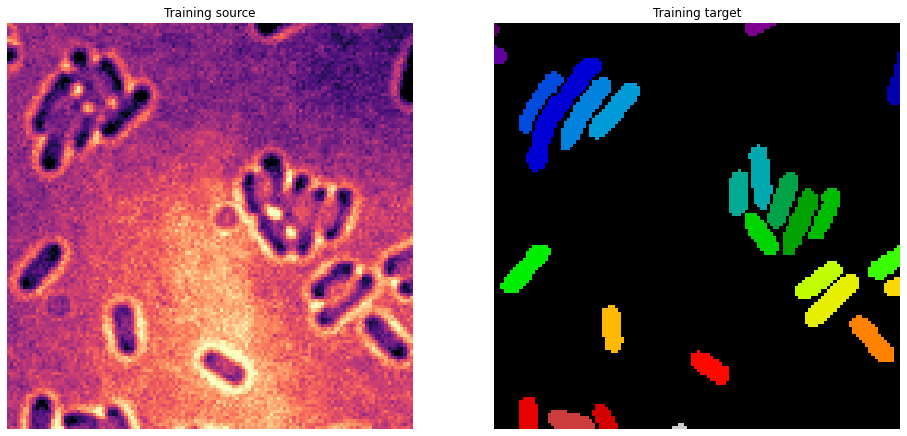

In [ ]:
#@markdown ###Path to training images:

Training_source = "/content/gdrive/MyDrive/Deep_learning_formation_MRI/Doc_JB_2022/data_salmonella/128x128_dataset/training_data/raw" #@param {type:"string"}
Training_target = "/content/gdrive/MyDrive/Deep_learning_formation_MRI/Doc_JB_2022/data_salmonella/128x128_dataset/training_data/instanciated_label" #@param {type:"string"}

#Define where the patch file will be saved
base = "/content"

# model name and path
#@markdown ###Name of the model and path to model folder:
model_name = "Test_omnipose" #@param {type:"string"}
model_path = "/content/gdrive/MyDrive/Deep_learning_formation_MRI/Doc_JB_2022/data_salmonella/128x128_dataset" #@param {type:"string"}

# other parameters for training.
#@markdown ###Training Parameters:
#@markdown Number of epochs:
number_of_epochs =  2000#@param {type:"number"}

Channel_to_use_for_training = "Grayscale" #@param ["Grayscale", "Blue", "Green", "Red"]

# @markdown ###If you have a secondary channel that can be used for training, for instance nuclei, choose it here:

Second_training_channel= "None" #@param ["None", "Blue", "Green", "Red"]


#@markdown ###Advanced Parameters

Use_Default_Advanced_Parameters = True #@param {type:"boolean"}
#@markdown ###If not, please input:
batch_size =  8#@param {type:"number"}
initial_learning_rate = 0.0002 #@param {type:"number"}
percentage_validation =  10#@param {type:"number"}

if (Use_Default_Advanced_Parameters): 
  print("Default advanced parameters enabled")
  batch_size = 8  
  initial_learning_rate = 0.0002
  percentage_validation = 10

#here we check that no model with the same name already exist, if so delete
if os.path.exists(model_path+'/'+model_name):
  print(bcolors.WARNING +"!! WARNING: "+model_name+" already exists and will be deleted in the following cell !!")
  print(bcolors.WARNING +"To continue training "+model_name+", choose a new model_name here, and load "+model_name+" in section 3.3"+W)
  
# Here we enable the cyto pre-trained model by default (in case the  cell is not ran)
model_to_load = "cyto"
# Here we disable data augmentation by default (in case the cell is not ran)

Use_Data_augmentation = True

# This will display a randomly chosen dataset input and output
random_choice = random.choice(os.listdir(Training_source))
x = io.imread(Training_source+"/"+random_choice)
norm = simple_norm(x, percent = 99)
y = io.imread(Training_target+"/"+random_choice)

# Find the number of channel in the input image

n_channel = 1 if x.ndim == 2 else x.shape[-1]


# Here we match the channel to number

if Channel_to_use_for_training == "Grayscale":
  Training_channel = 0

  if not n_channel == 1:
      print(bcolors.WARNING +"!! WARNING: your image has more than one channel, choose which channel you want to use for trainning !!")

if Channel_to_use_for_training == "Blue":
  Training_channel = 3

if Channel_to_use_for_training == "Green":
  Training_channel = 2

if Channel_to_use_for_training == "Red":
  Training_channel = 1


if Second_training_channel == "Blue":
  Second_training_channel = 3

if Second_training_channel == "Green":
  Second_training_channel = 2

if Second_training_channel == "Red":
  Second_training_channel = 1

if Second_training_channel == "None":
  Second_training_channel = 0


if n_channel ==1:

  f=plt.figure(figsize=(16,8))
  plt.subplot(1,2,1)
  plt.imshow(x, norm=norm, cmap='magma', interpolation='nearest')
  plt.title('Training source')
  plt.axis('off');

  plt.subplot(1,2,2)
  plt.imshow(y,cmap='nipy_spectral', interpolation='nearest')
  plt.title('Training target')
  plt.axis('off');

  plt.savefig('/content/TrainingDataExample_Cellpose2D.png',bbox_inches='tight',pad_inches=0)

else:

  f=plt.figure(figsize=(20,10))
  plt.subplot(1,3,1)
  plt.imshow(x, interpolation='nearest')
  plt.title('Training source')
  plt.axis('off');

  plt.subplot(1,3,2)
  plt.imshow(x[:, :, int(Training_channel-1)],cmap='magma', interpolation='nearest')
  plt.title('Channel used for training')
  plt.axis('off');

  plt.subplot(1,3,3)
  plt.imshow(y,cmap='nipy_spectral', interpolation='nearest')
  plt.title('Training target')
  plt.axis('off');

  plt.savefig('/content/TrainingDataExample_Cellpose2D.png',bbox_inches='tight',pad_inches=0)

## **3.2. Data augmentation**
---
<font size = 4>

<font size = 4>Data augmentation can improve training progress by amplifying differences in the dataset. This can be useful if the available dataset is small since, in this case, it is possible that a network could quickly learn every example in the dataset (overfitting), without augmentation. Augmentation is not necessary for training and if your training dataset is large you should disable it.

<font size = 4>By default, a x4 data augmentation is enabled in this notebook.

In [ ]:
#Data augmentation

Use_Data_augmentation = True #@param {type:"boolean"}

if Use_Data_augmentation:
  print(bcolors.WARNING+"Data augmentation enabled")
  Multiply_dataset_by = 4


if not Use_Data_augmentation:
  print(bcolors.WARNING+"Data augmentation disabled") 

Data augmentation enabled



## **3.3. Using weights from a pre-trained model as initial weights**
---
<font size = 4>  Here, you can set the path to a pre-trained model from which the weights can be extracted and used as a starting point for this training session. **This pre-trained model needs to be a Cellpose model**. 

<font size = 4>  You can also use the pretrained models already available in Cellpose: 

- The cytoplasm model in cellpose is trained on two-channel images, where the first channel is the channel to segment, and the second channel is an optional nuclear channel.

- The cytoplasm2 model is an updated cytoplasm model trained with user-submitted images.

- The nuclear model in cellpose is trained on two-channel images, where the first channel is the channel to segment, and the second channel is always set to an array of zeros.

<font size = 4> This option allows you to perform training over multiple Colab runtimes or to do transfer learning using models trained outside of ZeroCostDL4Mic. **You do not need to run this section if you want to train a network from scratch**.


In [ ]:
# @markdown ##Loading weights from a pre-trained network

Use_pretrained_model = False #@param {type:"boolean"}

Pretrained_model = "Cytoplasm2" #@param ["Cytoplasm","Cytoplasm2", "Nuclei", "Own_model"]

#@markdown ###If using your own model, please provide the path to the model (not the folder):
pretrained_model_path = "" #@param {type:"string"}

# --------------------- Check if we load a previously trained model ------------------------

if Use_pretrained_model == True :

  if Pretrained_model == "Own_model":    

    model_to_load = pretrained_model_path

    print('The model '+ str(model_to_load) + "will be used as a starting point")

  if Pretrained_model == "Cytoplasm":
    model_to_load = "cyto"
    print('The model Cytoplasm will be used as a starting point')

  if Pretrained_model == "Cytoplasm2":
    model_to_load = "cyto2"
    print('The model Cytoplasm2 (cyto2) will be used as a starting point')

  if Pretrained_model == "Nuclei":
    model_to_load = "nuclei"
    print('The model nuclei will be used as a starting point')

else:
  model_to_load = None
  print(bcolors.WARNING+'No pretrained network will be used.')



No pretrained network will be used.


#**4. Train the network**
---

In [ ]:
#@markdown ##Create the model and dataset objects


# Here we check that the model destination folder is empty
if os.path.exists(model_path+'/'+model_name):
  print(bcolors.WARNING +"!! WARNING: Model folder already exists and has been removed !!" + W)
  shutil.rmtree(model_path+'/'+model_name)

os.makedirs(model_path+"/"+model_name)


#To use cellpose to work we need to organise the data in a way the network can understand

# Here we count the number of files in the training target folder
Filelist = os.listdir(Training_target)
number_files = len(Filelist)

# Here we count the number of file to use for validation
Image_for_validation =  int((number_files)*(percentage_validation/100))

if Image_for_validation == 0:
  Image_for_validation = 1

Saving_path= "/content/"+model_name

if os.path.exists(Saving_path):
  shutil.rmtree(Saving_path)
os.makedirs(Saving_path)

train_folder = Saving_path+"/train_folder"
os.makedirs(train_folder)

test_folder = Saving_path+"/test_folder"
os.makedirs(test_folder)

index = 0

print('Copying training source data...')
for f in tqdm(os.listdir(Training_source)):  
    short_name = os.path.splitext(f)

    if index < Image_for_validation:
      shutil.copyfile(Training_source+"/"+f, test_folder+"/"+short_name[0]+"_img.tif")
      shutil.copyfile(Training_target+"/"+f, test_folder+"/"+short_name[0]+"_masks.tif")    
    else:
      shutil.copyfile(Training_source+"/"+f, train_folder+"/"+short_name[0]+"_img.tif")
      shutil.copyfile(Training_target+"/"+f, train_folder+"/"+short_name[0]+"_masks.tif")    
    index = index +1
    
print("Done")

pdf_export(augmentation = Use_Data_augmentation, pretrained_model = Use_pretrained_model)



## **4.2. Start Training**
---

<font size = 4>When playing the cell below you should see updates after each epoch (round). Network training can take some time.

<font size = 4>* **CRITICAL NOTE:** Training is currently done using Torch.

<font size = 4>* **CRITICAL NOTE:** Google Colab has a time limit for processing (to prevent using GPU power for datamining). Training time must be less than 12 hours! If training takes longer than 12 hours, please decrease the number of epochs or number of patches. Another way circumvent this is to save the parameters of the model after training and start training again from this point.


In [ ]:
#@markdown ##Start training

start = time.time()

if not Use_Data_augmentation:
  #!python -m cellpose --train --use_gpu --mxnet --fast_mode --dir "$train_folder" --test_dir "$test_folder" --pretrained_model $model_to_load --chan $Training_channel --chan2 $Second_training_channel --n_epochs $number_of_epochs --learning_rate $initial_learning_rate --batch_size $batch_size --img_filter img --mask_filter masks
  !python -m cellpose --train --use_gpu --fast_mode --dir "$train_folder" --test_dir "$test_folder" --pretrained_model $model_to_load --chan $Training_channel --chan2 $Second_training_channel --n_epochs $number_of_epochs --learning_rate $initial_learning_rate --batch_size $batch_size --img_filter img --mask_filter masks --verbose

else:
  #!python -m cellpose --train --use_gpu --mxnet --dir "$train_folder" --test_dir "$test_folder" --pretrained_model $model_to_load --chan $Training_channel --chan2 $Second_training_channel  --n_epochs $number_of_epochs --learning_rate $initial_learning_rate --batch_size $batch_size --img_filter img --mask_filter masks
  !python -m cellpose --train --use_gpu --fast_mode --dir "$train_folder" --test_dir "$test_folder" --pretrained_model $model_to_load --chan $Training_channel --chan2 $Second_training_channel --n_epochs $number_of_epochs --learning_rate $initial_learning_rate --batch_size $batch_size --img_filter img --mask_filter masks --verbose


#Settings
# --check_mkl', action='store_true', help='check if mkl working'

#'--mkldnn', action='store_true', help='for mxnet, force MXNET_SUBGRAPH_BACKEND = "MKLDNN"')

#'--train', action='store_true', help='train network using images in dir')
#'--dir', required=False, help='folder containing data to run or train on')
#  '--mxnet', action='store_true', help='use mxnet')
#  '--img_filter', required=False, default=[], type=str, help='end string for images to run on')
#  '--use_gpu', action='store_true', help='use gpu if mxnet with cuda installed')
#   '--fast_mode', action='store_true', help="make code run faster by turning off 4 network averaging")
#  '--resample', action='store_true', help="run dynamics on full image (slower for images with large diameters)")
# '--no_interp', action='store_true', help='do not interpolate when running dynamics (was default)')
#  '--do_3D', action='store_true',  help='process images as 3D stacks of images (nplanes x nchan x Ly x Lx')
   
# settings for training
#    parser.add_argument('--train_size', action='store_true', help='train size network at end of training')
#    parser.add_argument('--mask_filter', required=False, default='_masks', type=str, help='end string for masks to run on')
#    parser.add_argument('--test_dir', required=False, default=[], type=str, help='folder containing test data (optional)')
#    parser.add_argument('--learning_rate', required=False, default=0.2, type=float, help='learning rate')
#    parser.add_argument('--n_epochs', required=False, default=500, type=int, help='number of epochs')
#    parser.add_argument('--batch_size', required=False, default=8, type=int, help='batch size')
#    parser.add_argument('--residual_on', required=False, default=1, type=int, help='use residual connections')
#    parser.add_argument('--style_on', required=False, default=1, type=int, help='use style vector')
#    parser.add_argument('--concatenation', required=False, dfault=0, type=int, help='concatenate downsampled layers with upsampled layers (off by default which means they are added)')



#Here we copy the model to the result folder after training

if os.path.exists(model_path+'/'+model_name):
  print(bcolors.WARNING +"!! WARNING: Model folder already exists and has been removed !!" + W)
  shutil.rmtree(model_path+'/'+model_name)
destination = shutil.copytree(Saving_path+"/train_folder/models", model_path+"/"+model_name)

# Displaying the time elapsed for training
dt = time.time() - start
mins, sec = divmod(dt, 60) 
hour, mins = divmod(mins, 60) 
print("Time elapsed:",hour, "hour(s)",mins,"min(s)",round(sec),"sec(s)")
print("Your model is also available here: "+str(model_path+"/"+model_name))


pdf_export(trained=True, augmentation = Use_Data_augmentation, pretrained_model = Use_pretrained_model)



2022-11-18 13:54:55,916 [INFO] WRITING LOG OUTPUT TO /root/.cellpose/run.log
2022-11-18 13:54:59,278 [INFO] ** TORCH CUDA version installed and working. **
2022-11-18 13:54:59,279 [INFO] >>>> using GPU
2022-11-18 13:54:59,368 [INFO] not all flows are present, running flow generation for all images
2022-11-18 13:54:59,461 [INFO] not all flows are present, running flow generation for all images
2022-11-18 13:54:59,491 [INFO] >>>> training from scratch
2022-11-18 13:54:59,491 [INFO] >>>> during training rescaling images to fixed diameter of 30.0 pixels
2022-11-18 13:54:59,762 [INFO] Training with rescale = 1.00
2022-11-18 13:54:59,966 [INFO] computing flows for labels
100% 89/89 [00:01<00:00, 60.40it/s]
2022-11-18 13:55:01,544 [INFO] computing flows for labels
100% 9/9 [00:00<00:00, 71.91it/s]
2022-11-18 13:55:01,678 [WARNING] 6 train images with number of masks less than min_train_masks (5), removing from train set
2022-11-18 13:55:01,706 [INFO] >>>> median diameter set to = 30
2022-11-1

# **5. Evaluate your model**
---

<font size = 4>This section allows the user to perform important quality checks on the validity and generalisability of the trained model.  


<font size = 4>**We highly recommend to perform quality control on all newly trained models.**




In [ ]:
# model name and path
#@markdown ###Do you want to assess the model you just trained ?
Use_the_current_trained_model = True #@param {type:"boolean"}

#@markdown ###If not, indicate which model you want to assess:

QC_model = "Bacteria_Omnipose" #@param ["Cytoplasm","Cytoplasm2", "Cytoplasm2_Omnipose", "Bacteria_Omnipose", "Nuclei", "Own_model"]

#@markdown ###If using your own model, please provide the path to the model (not the folder):

QC_model_path = "/content/gdrive/MyDrive/Deep_learning_formation_MRI/Doc_JB_2022/data_salmonella/128x128_dataset/Test_omnipose/cellpose_residual_on_style_on_concatenation_off_train_folder_2022_11_18_13_55_01.678661" #@param {type:"string"}

#@markdown ###If using the Cellpose or Omnipose models, please indicate where you want to save the results:
Saving_path = "/content/gdrive/MyDrive/Deep_learning_formation_MRI/Doc_JB_2022/data_salmonella/128x128_dataset/test_omnipose" #@param {type:"string"}


if Use_the_current_trained_model :

  list_files = os.listdir(model_path+"/"+model_name)
  
  QC_model_path = model_path+"/"+model_name+"/"+list_files[0]
  QC_model = "Own_model"

  #model = models.CellposeModel(gpu=True, pretrained_model=QC_model_path, torch=False, diam_mean=30.0, net_avg=True, device=None, residual_on=True, style_on=True, concatenation=False)
  model = models.CellposeModel(gpu=True, pretrained_model=QC_model_path, torch=True, diam_mean=30.0, net_avg=True, device=None, residual_on=True, style_on=True, concatenation=False)

  QC_model_folder = os.path.dirname(QC_model_path)
  QC_model_name = os.path.basename(QC_model_folder)
  Saving_path = QC_model_folder

  print("The "+str(QC_model_name)+" model will be evaluated")

if not Use_the_current_trained_model:

  if QC_model == "Cytoplasm":
    model = models.Cellpose(gpu=True, model_type="cyto")
    QC_model_folder = Saving_path
    QC_model_name = "Cytoplasm"

    print('The model "Cytoplasm" will be evaluated')

  if QC_model == "Cytoplasm2":
    model = models.Cellpose(gpu=True, model_type="cyto2")
    QC_model_folder = Saving_path
    QC_model_name = "Cytoplasm2"

    print('The model "Cytoplasm" will be evaluated')

  if QC_model == "Cytoplasm2_Omnipose":
    model = models.Cellpose(gpu=True, model_type="cyto2_omni")
    QC_model_folder = Saving_path
    QC_model_name = "Cytoplasm2_Omnipose"
    print("The model Cytoplasm2_Omnipose will be evaluated") 

  if QC_model == "Bacteria_Omnipose":
    model = models.Cellpose(gpu=True, model_type="bact_omni")
    QC_model_folder = Saving_path
    QC_model_name = "Bacteria_Omnipose"
    print("The model Bacteria_omnipose will be evaluated")

  if QC_model == "Nuclei":
    model = models.Cellpose(gpu=True, model_type="nuclei")

    QC_model_folder = Saving_path
    QC_model_name = "Nuclei"

    print('The model "Nuclei" will be evaluated')
  
  if QC_model == "Own_model":

    if os.path.exists(QC_model_path):
      model = models.CellposeModel(gpu=True, pretrained_model=QC_model_path, torch=True, diam_mean=30.0, net_avg=True, device=None, residual_on=True, style_on=True, concatenation=False)
      
      QC_model_folder = os.path.dirname(QC_model_path)
      Saving_path = QC_model_folder
      QC_model_name = os.path.basename(QC_model_folder)
      print("The "+str(QC_model_name)+" model will be evaluated")
      
    else:  
      print(bcolors.WARNING+'!! WARNING: The chosen model does not exist !!')
      print('Please make sure you provide a valid model path and model name before proceeding further.')

#Here we make the folder to save the resuslts if it does not exists

if not Saving_path == "":
  if os.path.exists(QC_model_folder) == False:
    os.makedirs(QC_model_folder)
else:
  print(bcolors.WARNING+'!! WARNING: Indicate where you want to save the results')


# Here we load the def that perform the QC, code taken from StarDist  https://github.com/mpicbg-csbd/stardist/blob/master/stardist/matching.py

import numpy as np
from numba import jit
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment
from collections import namedtuple


matching_criteria = dict()

def label_are_sequential(y):
    """ returns true if y has only sequential labels from 1... """
    labels = np.unique(y)
    return (set(labels)-{0}) == set(range(1,1+labels.max()))


def is_array_of_integers(y):
    return isinstance(y,np.ndarray) and np.issubdtype(y.dtype, np.integer)


def _check_label_array(y, name=None, check_sequential=False):
    err = ValueError("{label} must be an array of {integers}.".format(
        label = 'labels' if name is None else name,
        integers = ('sequential ' if check_sequential else '') + 'non-negative integers',
    ))
    is_array_of_integers(y) or print("An error occured")
    if check_sequential:
        label_are_sequential(y) or print("An error occured")
    else:
        y.min() >= 0 or print("An error occured")
    return True


def label_overlap(x, y, check=True):
    if check:
        _check_label_array(x,'x',True)
        _check_label_array(y,'y',True)
        x.shape == y.shape or _raise(ValueError("x and y must have the same shape"))
    return _label_overlap(x, y)

@jit(nopython=True)
def _label_overlap(x, y):
    x = x.ravel()
    y = y.ravel()
    overlap = np.zeros((1+x.max(),1+y.max()), dtype=np.uint)
    for i in range(len(x)):
        overlap[x[i],y[i]] += 1
    return overlap


def intersection_over_union(overlap):
    _check_label_array(overlap,'overlap')
    if np.sum(overlap) == 0:
        return overlap
    n_pixels_pred = np.sum(overlap, axis=0, keepdims=True)
    n_pixels_true = np.sum(overlap, axis=1, keepdims=True)
    return overlap / (n_pixels_pred + n_pixels_true - overlap)

matching_criteria['iou'] = intersection_over_union


def intersection_over_true(overlap):
    _check_label_array(overlap,'overlap')
    if np.sum(overlap) == 0:
        return overlap
    n_pixels_true = np.sum(overlap, axis=1, keepdims=True)
    return overlap / n_pixels_true

matching_criteria['iot'] = intersection_over_true


def intersection_over_pred(overlap):
    _check_label_array(overlap,'overlap')
    if np.sum(overlap) == 0:
        return overlap
    n_pixels_pred = np.sum(overlap, axis=0, keepdims=True)
    return overlap / n_pixels_pred

matching_criteria['iop'] = intersection_over_pred


def precision(tp,fp,fn):
    return tp/(tp+fp) if tp > 0 else 0
def recall(tp,fp,fn):
    return tp/(tp+fn) if tp > 0 else 0
def accuracy(tp,fp,fn):
    # also known as "average precision" (?)
    # -> https://www.kaggle.com/c/data-science-bowl-2018#evaluation
    return tp/(tp+fp+fn) if tp > 0 else 0
def f1(tp,fp,fn):
    # also known as "dice coefficient"
    return (2*tp)/(2*tp+fp+fn) if tp > 0 else 0


def _safe_divide(x,y):
    return x/y if y>0 else 0.0

def matching(y_true, y_pred, thresh=0.5, criterion='iou', report_matches=False):
    """Calculate detection/instance segmentation metrics between ground truth and predicted label images.
    Currently, the following metrics are implemented:
    'fp', 'tp', 'fn', 'precision', 'recall', 'accuracy', 'f1', 'criterion', 'thresh', 'n_true', 'n_pred', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'
    Corresponding objects of y_true and y_pred are counted as true positives (tp), false positives (fp), and false negatives (fn)
    whether their intersection over union (IoU) >= thresh (for criterion='iou', which can be changed)
    * mean_matched_score is the mean IoUs of matched true positives
    * mean_true_score is the mean IoUs of matched true positives but normalized by the total number of GT objects
    * panoptic_quality defined as in Eq. 1 of Kirillov et al. "Panoptic Segmentation", CVPR 2019
    Parameters
    ----------
    y_true: ndarray
        ground truth label image (integer valued)
        predicted label image (integer valued)
    thresh: float
        threshold for matching criterion (default 0.5)
    criterion: string
        matching criterion (default IoU)
    report_matches: bool
        if True, additionally calculate matched_pairs and matched_scores (note, that this returns even gt-pred pairs whose scores are below  'thresh')
    Returns
    -------
    Matching object with different metrics as attributes
    Examples
    --------
    >>> y_true = np.zeros((100,100), np.uint16)
    >>> y_true[10:20,10:20] = 1
    >>> y_pred = np.roll(y_true,5,axis = 0)
    >>> stats = matching(y_true, y_pred)
    >>> print(stats)
    Matching(criterion='iou', thresh=0.5, fp=1, tp=0, fn=1, precision=0, recall=0, accuracy=0, f1=0, n_true=1, n_pred=1, mean_true_score=0.0, mean_matched_score=0.0, panoptic_quality=0.0)
    """
    _check_label_array(y_true,'y_true')
    _check_label_array(y_pred,'y_pred')
    y_true.shape == y_pred.shape or _raise(ValueError("y_true ({y_true.shape}) and y_pred ({y_pred.shape}) have different shapes".format(y_true=y_true, y_pred=y_pred)))
    criterion in matching_criteria or _raise(ValueError("Matching criterion '%s' not supported." % criterion))
    if thresh is None: thresh = 0
    thresh = float(thresh) if np.isscalar(thresh) else map(float,thresh)

    y_true, _, map_rev_true = relabel_sequential(y_true)
    y_pred, _, map_rev_pred = relabel_sequential(y_pred)

    overlap = label_overlap(y_true, y_pred, check=False)
    scores = matching_criteria[criterion](overlap)
    assert 0 <= np.min(scores) <= np.max(scores) <= 1

    # ignoring background
    scores = scores[1:,1:]
    n_true, n_pred = scores.shape
    n_matched = min(n_true, n_pred)

    def _single(thr):
        not_trivial = n_matched > 0 and np.any(scores >= thr)
        if not_trivial:
            # compute optimal matching with scores as tie-breaker
            costs = -(scores >= thr).astype(float) - scores / (2*n_matched)
            true_ind, pred_ind = linear_sum_assignment(costs)
            assert n_matched == len(true_ind) == len(pred_ind)
            match_ok = scores[true_ind,pred_ind] >= thr
            tp = np.count_nonzero(match_ok)
        else:
            tp = 0
        fp = n_pred - tp
        fn = n_true - tp
        # assert tp+fp == n_pred
        # assert tp+fn == n_true

        # the score sum over all matched objects (tp)
        sum_matched_score = np.sum(scores[true_ind,pred_ind][match_ok]) if not_trivial else 0.0

        # the score average over all matched objects (tp)
        mean_matched_score = _safe_divide(sum_matched_score, tp)
        # the score average over all gt/true objects
        mean_true_score    = _safe_divide(sum_matched_score, n_true)
        panoptic_quality   = _safe_divide(sum_matched_score, tp+fp/2+fn/2)

        stats_dict = dict (
            criterion          = criterion,
            thresh             = thr,
            fp                 = fp,
            tp                 = tp,
            fn                 = fn,
            precision          = precision(tp,fp,fn),
            recall             = recall(tp,fp,fn),
            accuracy           = accuracy(tp,fp,fn),
            f1                 = f1(tp,fp,fn),
            n_true             = n_true,
            n_pred             = n_pred,
            mean_true_score    = mean_true_score,
            mean_matched_score = mean_matched_score,
            panoptic_quality   = panoptic_quality,
        )
        if bool(report_matches):
            if not_trivial:
                stats_dict.update (
                    # int() to be json serializable
                    matched_pairs  = tuple((int(map_rev_true[i]),int(map_rev_pred[j])) for i,j in zip(1+true_ind,1+pred_ind)),
                    matched_scores = tuple(scores[true_ind,pred_ind]),
                    matched_tps    = tuple(map(int,np.flatnonzero(match_ok))),
                )
            else:
                stats_dict.update (
                    matched_pairs  = (),
                    matched_scores = (),
                    matched_tps    = (),
                )
        return namedtuple('Matching',stats_dict.keys())(*stats_dict.values())

    return _single(thresh) if np.isscalar(thresh) else tuple(map(_single,thresh))



def matching_dataset(y_true, y_pred, thresh=0.5, criterion='iou', by_image=False, show_progress=True, parallel=False):
    """matching metrics for list of images, see `stardist.matching.matching`
    """
    len(y_true) == len(y_pred) or _raise(ValueError("y_true and y_pred must have the same length."))
    return matching_dataset_lazy (
        tuple(zip(y_true,y_pred)), thresh=thresh, criterion=criterion, by_image=by_image, show_progress=show_progress, parallel=parallel,
    )



def matching_dataset_lazy(y_gen, thresh=0.5, criterion='iou', by_image=False, show_progress=True, parallel=False):

    expected_keys = set(('fp', 'tp', 'fn', 'precision', 'recall', 'accuracy', 'f1', 'criterion', 'thresh', 'n_true', 'n_pred', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'))

    single_thresh = False
    if np.isscalar(thresh):
        single_thresh = True
        thresh = (thresh,)

    tqdm_kwargs = {}
    tqdm_kwargs['disable'] = not bool(show_progress)
    if int(show_progress) > 1:
        tqdm_kwargs['total'] = int(show_progress)

    # compute matching stats for every pair of label images
    if parallel:
        from concurrent.futures import ThreadPoolExecutor
        fn = lambda pair: matching(*pair, thresh=thresh, criterion=criterion, report_matches=False)
        with ThreadPoolExecutor() as pool:
            stats_all = tuple(pool.map(fn, tqdm(y_gen,**tqdm_kwargs)))
    else:
        stats_all = tuple (
            matching(y_t, y_p, thresh=thresh, criterion=criterion, report_matches=False)
            for y_t,y_p in tqdm(y_gen,**tqdm_kwargs)
        )

    # accumulate results over all images for each threshold separately
    n_images, n_threshs = len(stats_all), len(thresh)
    accumulate = [{} for _ in range(n_threshs)]
    for stats in stats_all:
        for i,s in enumerate(stats):
            acc = accumulate[i]
            for k,v in s._asdict().items():
                if k == 'mean_true_score' and not bool(by_image):
                    # convert mean_true_score to "sum_matched_score"
                    acc[k] = acc.setdefault(k,0) + v * s.n_true
                else:
                    try:
                        acc[k] = acc.setdefault(k,0) + v
                    except TypeError:
                        pass

    # normalize/compute 'precision', 'recall', 'accuracy', 'f1'
    for thr,acc in zip(thresh,accumulate):
        set(acc.keys()) == expected_keys or _raise(ValueError("unexpected keys"))
        acc['criterion'] = criterion
        acc['thresh'] = thr
        acc['by_image'] = bool(by_image)
        if bool(by_image):
            for k in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
                acc[k] /= n_images
        else:
            tp, fp, fn, n_true = acc['tp'], acc['fp'], acc['fn'], acc['n_true']
            sum_matched_score = acc['mean_true_score']

            mean_matched_score = _safe_divide(sum_matched_score, tp)
            mean_true_score    = _safe_divide(sum_matched_score, n_true)
            panoptic_quality   = _safe_divide(sum_matched_score, tp+fp/2+fn/2)

            acc.update(
                precision          = precision(tp,fp,fn),
                recall             = recall(tp,fp,fn),
                accuracy           = accuracy(tp,fp,fn),
                f1                 = f1(tp,fp,fn),
                mean_true_score    = mean_true_score,
                mean_matched_score = mean_matched_score,
                panoptic_quality   = panoptic_quality,
            )

    accumulate = tuple(namedtuple('DatasetMatching',acc.keys())(*acc.values()) for acc in accumulate)
    return accumulate[0] if single_thresh else accumulate



# copied from scikit-image master for now (remove when part of a release)
def relabel_sequential(label_field, offset=1):
    """Relabel arbitrary labels to {`offset`, ... `offset` + number_of_labels}.
    This function also returns the forward map (mapping the original labels to
    the reduced labels) and the inverse map (mapping the reduced labels back
    to the original ones).
    Parameters
    ----------
    label_field : numpy array of int, arbitrary shape
        An array of labels, which must be non-negative integers.
    offset : int, optional
        The return labels will start at `offset`, which should be
        strictly positive.
    Returns
    -------
    relabeled : numpy array of int, same shape as `label_field`
        The input label field with labels mapped to
        {offset, ..., number_of_labels + offset - 1}.
        The data type will be the same as `label_field`, except when
        offset + number_of_labels causes overflow of the current data type.
    forward_map : numpy array of int, shape ``(label_field.max() + 1,)``
        The map from the original label space to the returned label
        space. Can be used to re-apply the same mapping. See examples
        for usage. The data type will be the same as `relabeled`.
    inverse_map : 1D numpy array of int, of length offset + number of labels
        The map from the new label space to the original space. This
        can be used to reconstruct the original label field from the
        relabeled one. The data type will be the same as `relabeled`.
    Notes
    -----
    The label 0 is assumed to denote the background and is never remapped.
    The forward map can be extremely big for some inputs, since its
    length is given by the maximum of the label field. However, in most
    situations, ``label_field.max()`` is much smaller than
    ``label_field.size``, and in these cases the forward map is
    guaranteed to be smaller than either the input or output images.
    Examples
    --------
    >>> from skimage.segmentation import relabel_sequential
    >>> label_field = np.array([1, 1, 5, 5, 8, 99, 42])
    >>> relab, fw, inv = relabel_sequential(label_field)
    >>> relab
    array([1, 1, 2, 2, 3, 5, 4])
    >>> fw
    array([0, 1, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0,
           0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5])
    >>> inv
    array([ 0,  1,  5,  8, 42, 99])
    >>> (fw[label_field] == relab).all()
    True
    >>> (inv[relab] == label_field).all()
    True
    >>> relab, fw, inv = relabel_sequential(label_field, offset=5)
    >>> relab
    array([5, 5, 6, 6, 7, 9, 8])
    """
    offset = int(offset)
    if offset <= 0:
        raise ValueError("Offset must be strictly positive.")
    if np.min(label_field) < 0:
        raise ValueError("Cannot relabel array that contains negative values.")
    max_label = int(label_field.max()) # Ensure max_label is an integer
    if not np.issubdtype(label_field.dtype, np.integer):
        new_type = np.min_scalar_type(max_label)
        label_field = label_field.astype(new_type)
    labels = np.unique(label_field)
    labels0 = labels[labels != 0]
    new_max_label = offset - 1 + len(labels0)
    new_labels0 = np.arange(offset, new_max_label + 1)
    output_type = label_field.dtype
    required_type = np.min_scalar_type(new_max_label)
    if np.dtype(required_type).itemsize > np.dtype(label_field.dtype).itemsize:
        output_type = required_type
    forward_map = np.zeros(max_label + 1, dtype=output_type)
    forward_map[labels0] = new_labels0
    inverse_map = np.zeros(new_max_label + 1, dtype=output_type)
    inverse_map[offset:] = labels0
    relabeled = forward_map[label_field]
    return relabeled, forward_map, inverse_map





The Test_omnipose model will be evaluated


## **5.1. Inspection of the loss function**
---

<font size = 4>First, it is good practice to evaluate the training progress by comparing the training loss with the validation loss. The latter is a metric which shows how well the network performs on a subset of unseen data which is set aside from the training dataset. For more information on this, see for example [this review](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6381354/) by Nichols *et al.*

<font size = 4>**Training loss** describes an error value after each epoch for the difference between the model's prediction and its ground-truth target.

<font size = 4>**Validation loss** describes the same error value between the model's prediction on a validation image and compared to it's target.

<font size = 4>During training both values should decrease before reaching a minimal value which does not decrease further even after more training. Comparing the development of the validation loss with the training loss can give insights into the model's performance.

<font size = 4>Decreasing **Training loss** and **Validation loss** indicates that training is still necessary and increasing the `number_of_epochs` is recommended. Note that the curves can look flat towards the right side, just because of the y-axis scaling. The network has reached convergence once the curves flatten out. After this point no further training is required. If the **Validation loss** suddenly increases again an the **Training loss** simultaneously goes towards zero, it means that the network is overfitting to the training data. In other words the network is remembering the exact patterns from the training data and no longer generalizes well to unseen data. In this case the training dataset has to be increased.




In [ ]:
#@markdown ###Not implemented yet

## **5.2. Error mapping and quality metrics estimation**
---
<font size = 4>This section will calculate the Intersection over Union score for all the images provided in the Source_QC_folder and Target_QC_folder ! The result for one of the image will also be displayed.

<font size = 4>The **Intersection over Union** (IuO) metric is a method that can be used to quantify the percent overlap between the target mask and your prediction output. **Therefore, the closer to 1, the better the performance.** This metric can be used to assess the quality of your model to accurately predict nuclei. 

<font size = 4>Here, the IuO is both calculated over the whole image and on a per-object basis. The value displayed below is the IuO value calculated over the entire image. The IuO value calculated on a per-object basis is used to calculate the other metrics displayed.

<font size = 4>“n_true” refers to the number of objects present in the ground truth image. “n_pred” refers to the number of objects present in the predicted image. 

<font size = 4>When a segmented object has an IuO value above 0.5 (compared to the corresponding ground truth), it is then considered a true positive. The number of “**true positives**” is available in the table below. The number of “false positive” is then defined as  “**false positive**” = “n_pred” - “true positive”. The number of “false negative” is defined as “false negative” = “n_true” - “true positive”.

<font size = 4>The mean_matched_score is the mean IoUs of matched true positives. The mean_true_score is the mean IoUs of matched true positives but normalized by the total number of ground truth objects. The panoptic_quality is calculated as described by [Kirillov et al. 2019](https://arxiv.org/abs/1801.00868).

<font size = 4>For more information about the other metric displayed, please consult the SI of the paper describing ZeroCostDL4Mic.

<font size = 4> The results can be found in the "*Quality Control*" folder which is located inside your "model_folder".

<font size = 4>**`model_choice`:** Choose the model to use to make predictions. This model needs to be a Cellpose model. You can also use the pretrained models already available in cellpose: 

- The cytoplasm model in cellpose is trained on two-channel images, where the first channel is the channel to segment, and the second channel is an optional nuclear channel.
- The cytoplasm2 model is an updated cytoplasm model trained with user-submitted images.

- The nuclear model in cellpose is trained on two-channel images, where the first channel is the channel to segment, and the second channel is always set to an array of zeros.

- The bacteria Omnipose model is an Omnipose model dedicated to the segmentation of bacteria or other elongated cells.

- The cytoplasm2 Omnipose model is an Omnipose model trained using the same dataset as the cellpose cytoplasm2 model.

<font size = 4>**`Channel_to_segment`:** Choose the channel to segment. If using single-channel grayscale images, choose "Grayscale".

<font size = 4>**`Nuclear_channel`:** If you are using a model that segment the "cytoplasm", you can use a nuclear channel to aid the segmentation. 

<font size = 4>**`Object_diameter`:** Indicate the diameter of the objects (cells or Nuclei) you want to segment (in pixel). If you input "0", this parameter will be estimated automatically for each of your images.

<font size = 4>**`Flow_threshold`:** This parameter controls the maximum allowed error of the flows for each mask. Increase this threshold if cellpose is not returning as many masks as you'd expect. Similarly, decrease this threshold if cellpose is returning too many ill-shaped masks. **Default value: 0.4**

<font size = 4>**`mask_threshold`:** The pixels greater than the mask_threshold are used to run dynamics and determine masks.  Decrease this threshold if cellpose is not returning as many masks as you'd expect. Similarly, increase this threshold if cellpose is returning too many masks, particularly from dim areas. **Default value: 0.0**

In [ ]:
#@markdown ##Choose the folders that contain your Quality Control dataset

Source_QC_folder = "/content/gdrive/MyDrive/Deep_learning_formation_MRI/Doc_JB_2022/data_salmonella/128x128_dataset/testing_data/mask" #@param{type:"string"}
Target_QC_folder = "/content/gdrive/MyDrive/Deep_learning_formation_MRI/Doc_JB_2022/data_salmonella/128x128_dataset/testing_data/instanciated_label" #@param{type:"string"}

Channel_to_segment= "Grayscale" #@param ["Grayscale", "Blue", "Green", "Red"]

# @markdown ###If you chose the model "cytoplasm" indicate if you also have a nuclear channel that can be used to aid the segmentation.

Nuclear_channel= "None" #@param ["None", "Blue", "Green", "Red"]

#@markdown ### Segmentation parameters:
Object_diameter =  0#@param {type:"number"}

Flow_threshold = 0.4 #@param {type:"slider", min:0.1, max:1.1, step:0.1}
mask_threshold=0 #@param {type:"slider", min:-6, max:6, step:1}

if Object_diameter is 0:
  Object_diameter = None
  print("The cell size will be estimated automatically for each image")


# Find the number of channel in the input image

random_choice = random.choice(os.listdir(Source_QC_folder))
x = io.imread(Source_QC_folder+"/"+random_choice)
n_channel = 1 if x.ndim == 2 else x.shape[-1]

if Channel_to_segment == "Grayscale":
  segment_channel = 0

  if not n_channel == 1:
      print(bcolors.WARNING +"!! WARNING: your image has more than one channel, choose which channel you want to use for QC !!")

if Channel_to_segment == "Blue":
  segment_channel = 3

if Channel_to_segment == "Green":
  segment_channel = 2

if Channel_to_segment == "Red":
  segment_channel = 1

if Nuclear_channel == "Blue":
  nuclear_channel = 3

if Nuclear_channel == "Green":
  nuclear_channel = 2

if Nuclear_channel == "Red":
  nuclear_channel = 1

if Nuclear_channel == "None":
  nuclear_channel = 0

if QC_model == "Cytoplasm":  
  channels=[segment_channel,nuclear_channel]

if QC_model == "Cytoplasm2_Omnipose":  
  channels=[segment_channel,nuclear_channel]

if QC_model == "Bacteria_Omnipose":  
  channels=[segment_channel,nuclear_channel]

if QC_model == "Cytoplasm2":  
  channels=[segment_channel,nuclear_channel]
  
if QC_model == "Nuclei":
  channels=[segment_channel,0]

if QC_model == "Own_model":
  channels=[segment_channel,nuclear_channel]

#Create a quality control Folder and check if the folder already exist
if os.path.exists(QC_model_folder+"/Quality Control") == False:
  os.makedirs(QC_model_folder+"/Quality Control")

if os.path.exists(QC_model_folder+"/Quality Control/Prediction"):
  shutil.rmtree(QC_model_folder+"/Quality Control/Prediction")
os.makedirs(QC_model_folder+"/Quality Control/Prediction")


# Here we need to make predictions

for name in os.listdir(Source_QC_folder):
  
  print("Performing prediction on: "+name)
  image = io.imread(Source_QC_folder+"/"+name) 

  short_name = os.path.splitext(name)
        
  if QC_model == "Own_model":
    masks, flows, styles = model.eval(image, diameter=Object_diameter, flow_threshold=Flow_threshold,mask_threshold=mask_threshold, channels=channels)
  else:
    masks, flows, styles, diams = model.eval(image, diameter=Object_diameter, flow_threshold=Flow_threshold,mask_threshold=mask_threshold, channels=channels)
            
  os.chdir(QC_model_folder+"/Quality Control/Prediction")
  imsave(str(short_name[0])+".tif", masks, compress=ZIP_DEFLATED)  
  
# Here we start testing the differences between GT and predicted masks

with open(QC_model_folder+"/Quality Control/Quality_Control for "+QC_model_name+".csv", "w", newline='') as file:
  writer = csv.writer(file, delimiter=",")
  writer.writerow(["image","Prediction v. GT Intersection over Union", "false positive", "true positive", "false negative", "precision", "recall", "accuracy", "f1 score", "n_true", "n_pred", "mean_true_score", "mean_matched_score", "panoptic_quality"])  

# define the images

  for n in os.listdir(Source_QC_folder):
    
    if not os.path.isdir(os.path.join(Source_QC_folder,n)):
      print('Running QC on: '+n)
      test_input = io.imread(os.path.join(Source_QC_folder,n))
      test_prediction = io.imread(os.path.join(QC_model_folder+"/Quality Control/Prediction",n))
      test_ground_truth_image = io.imread(os.path.join(Target_QC_folder, n))

      # Calculate the matching (with IoU threshold `thresh`) and all metrics

      stats = matching(test_ground_truth_image, test_prediction, thresh=0.5)
      

      #Convert pixel values to 0 or 255
      test_prediction_0_to_255 = test_prediction
      test_prediction_0_to_255[test_prediction_0_to_255>0] = 255

      #Convert pixel values to 0 or 255
      test_ground_truth_0_to_255 = test_ground_truth_image
      test_ground_truth_0_to_255[test_ground_truth_0_to_255>0] = 255


      # Intersection over Union metric

      intersection = np.logical_and(test_ground_truth_0_to_255, test_prediction_0_to_255)
      union = np.logical_or(test_ground_truth_0_to_255, test_prediction_0_to_255)
      iou_score =  np.sum(intersection) / np.sum(union)
      writer.writerow([n, str(iou_score), str(stats.fp), str(stats.tp), str(stats.fn), str(stats.precision), str(stats.recall), str(stats.accuracy), str(stats.f1), str(stats.n_true), str(stats.n_pred), str(stats.mean_true_score), str(stats.mean_matched_score), str(stats.panoptic_quality)])

from tabulate import tabulate

df = pd.read_csv (QC_model_folder+"/Quality Control/Quality_Control for "+QC_model_name+".csv")
print(tabulate(df, headers='keys', tablefmt='psql'))


from astropy.visualization import simple_norm

# ------------- For display ------------
print('--------------------------------------------------------------')
@interact
def show_QC_results(file = os.listdir(Source_QC_folder)):
  

  plt.figure(figsize=(25,5))
  if n_channel > 1:
    source_image = io.imread(os.path.join(Source_QC_folder, file))
  if n_channel == 1:
    source_image = io.imread(os.path.join(Source_QC_folder, file), as_gray = True)

  target_image = io.imread(os.path.join(Target_QC_folder, file), as_gray = True)
  prediction = io.imread(QC_model_folder+"/Quality Control/Prediction/"+file, as_gray = True)

  stats = matching(prediction, target_image, thresh=0.5)

  target_image_mask = np.empty_like(target_image)
  target_image_mask[target_image > 0] = 255
  target_image_mask[target_image == 0] = 0
  
  prediction_mask = np.empty_like(prediction)
  prediction_mask[prediction > 0] = 255
  prediction_mask[prediction == 0] = 0

  intersection = np.logical_and(target_image_mask, prediction_mask)
  union = np.logical_or(target_image_mask, prediction_mask)
  iou_score =  np.sum(intersection) / np.sum(union)

  norm = simple_norm(source_image, percent = 99)

  #Input
  plt.subplot(1,4,1)
  plt.axis('off')
  if n_channel > 1:
    plt.imshow(source_image)
  if n_channel == 1:
    plt.imshow(source_image, aspect='equal', norm=norm, cmap='magma', interpolation='nearest')
  plt.title('Input')

  #Ground-truth
  plt.subplot(1,4,2)
  plt.axis('off')
  plt.imshow(target_image_mask, aspect='equal', cmap='Greens')
  plt.title('Ground Truth')

  #Prediction
  plt.subplot(1,4,3)
  plt.axis('off')
  plt.imshow(prediction_mask, aspect='equal', cmap='Purples')
  plt.title('Prediction')

  #Overlay
  plt.subplot(1,4,4)
  plt.axis('off')
  plt.imshow(target_image_mask, cmap='Greens')
  plt.imshow(prediction_mask, alpha=0.5, cmap='Purples')
  plt.title('Ground Truth and Prediction, Intersection over Union:'+str(round(iou_score,3 )));
  plt.savefig(QC_model_folder+'/Quality Control/QC_example_data.png',bbox_inches='tight',pad_inches=0)


full_QC_model_path = QC_model_folder+'/'
qc_pdf_export()



The cell size will be estimated automatically for each image
Performing prediction on: 019_raw.tif
Performing prediction on: 032_raw.tif
Performing prediction on: 026_raw.tif
Performing prediction on: 018_raw.tif
Performing prediction on: 023_raw.tif
Performing prediction on: 027_raw.tif
Performing prediction on: 015_raw.tif
Performing prediction on: 021_raw.tif
Performing prediction on: 017_raw.tif
Performing prediction on: 024_raw.tif
Performing prediction on: 025_raw.tif
Performing prediction on: 022_raw.tif
Performing prediction on: 016_raw.tif
Performing prediction on: 020_raw.tif
Performing prediction on: 014_raw.tif
Performing prediction on: 005_raw.tif
Performing prediction on: 012_raw.tif
Performing prediction on: 008_raw.tif
Performing prediction on: 011_raw.tif
Performing prediction on: 007_raw.tif
Performing prediction on: 006_raw.tif
Performing prediction on: 010_raw.tif
Performing prediction on: 009_raw.tif
Performing prediction on: 001_raw.tif
Performing prediction on: 0

Performing prediction on: 002_raw.tif
Performing prediction on: 003_raw.tif
Performing prediction on: 013_raw.tif
Performing prediction on: 028_raw.tif
Performing prediction on: 029_raw.tif
Performing prediction on: 030_raw.tif
Performing prediction on: 031_raw.tif
Running QC on: 019_raw.tif
Running QC on: 032_raw.tif
Running QC on: 026_raw.tif
Running QC on: 018_raw.tif
Running QC on: 023_raw.tif
Running QC on: 027_raw.tif
Running QC on: 015_raw.tif
Running QC on: 021_raw.tif
Running QC on: 017_raw.tif
Running QC on: 024_raw.tif
Running QC on: 025_raw.tif
Running QC on: 022_raw.tif
Running QC on: 016_raw.tif
Running QC on: 020_raw.tif
Running QC on: 014_raw.tif
Running QC on: 005_raw.tif
Running QC on: 012_raw.tif
Running QC on: 008_raw.tif
Running QC on: 011_raw.tif
Running QC on: 007_raw.tif
Running QC on: 006_raw.tif
Running QC on: 010_raw.tif
Running QC on: 009_raw.tif
Running QC on: 001_raw.tif
Running QC on: 004_raw.tif
Running QC on: 002_raw.tif
Running QC on: 003_raw.tif
Runni

interactive(children=(Dropdown(description='file', options=('019_raw.tif', '032_raw.tif', '026_raw.tif', '018_…

# **6. Using the trained model**

---

<font size = 4>In this section the unseen data is processed using the trained model (in section 4). First, your unseen images are uploaded and prepared for prediction. After that your trained model from section 4 is activated and finally saved into your Google Drive.



## **6.1 Generate prediction(s) from unseen dataset (2D and 2D + t data)**
---

<font size = 4>The current trained model (from section 4.3) can now be used to process images. If an older model needs to be used, please untick the **Use_the_current_trained_model** box and enter the model's name and path to use. Predicted output images are saved in your **Prediction_folder** folder as restored image stacks (ImageJ-compatible TIFF images).

<font size = 4>**`Data_folder`:** This folder should contain the images that you want to predict using the network that you will train.

<font size = 4>**`Result_folder`:** This folder will contain the predicted output.

<font size = 4>**`Data_type`:** Please indicate if the images you want to predict are single images or stacks

<font size = 4>**`model_choice`:** Choose the model to use to make predictions. This model needs to be a Cellpose model. You can also use the pretrained models already available in cellpose: 

- The cytoplasm model in cellpose is trained on two-channel images, where the first channel is the channel to segment, and the second channel is an optional nuclear channel.

- The cytoplasm2 model is an updated cytoplasm model trained with user-submitted images.

- The nuclear model in cellpose is trained on two-channel images, where the first channel is the channel to segment, and the second channel is always set to an array of zeros.

- The bacteria Omnipose model is an Omnipose model dedicated to the segmentation of bacteria or other elongated cells.

- The cytoplasm2 Omnipose model is an Omnipose model trained using the same dataset as the cellpose cytoplasm2 model.

<font size = 4>**`Channel_to_segment`:** Choose the channel to segment. If using single-channel grayscale images, choose "Grayscale".

<font size = 4>**`Nuclear_channel`:** If you are using a model that segment the "cytoplasm", you can use a nuclear channel to aid the segmentation. 

<font size = 4>**`Object_diameter`:** Indicate the diameter of the objects (cells or Nuclei) you want to segment (in pixel). If you input "0", this parameter will be estimated automatically for each of your images.

<font size = 4>**`Flow_threshold`:** This parameter controls the maximum allowed error of the flows for each mask. Increase this threshold if cellpose is not returning as many masks as you'd expect. Similarly, decrease this threshold if cellpose is returning too many ill-shaped masks. **Default value: 0.4**

<font size = 4>**`mask_threshold`:** The pixels greater than the mask_threshold are used to run dynamics and determine masks.  Decrease this threshold if cellpose is not returning as many masks as you'd expect. Similarly, increase this threshold if cellpose is returning too many masks, particularly from dim areas. **Default value: 0.0**

<font size = 4>**IMPORTANT:** One example result will be displayed first so that you can assess the quality of the prediction and change your settings accordingly. Once the most suitable settings have been chosen, press on the yellow button "process your images".








In [ ]:

#@markdown ### Provide the path to your dataset and to the folder where the predictions are saved, then play the cell to predict outputs from your unseen images.

Data_folder = "/content/gdrive/MyDrive/Deep_learning_formation_MRI/Doc_JB_2022/data_salmonella/128x128_dataset_normalized/training_data/raw" #@param {type:"string"}
Result_folder = "/content/gdrive/MyDrive/Deep_learning_formation_MRI/Doc_JB_2022/data_salmonella/128x128_dataset_normalized/test_omnipose" #@param {type:"string"}

#@markdown ###Are your data single images or stacks?

Data_type = "Single_Images" #@param ["Single_Images", "Stacks (2D + t)"]

#@markdown ###What model do you want to use?

model_choice = "Own_model" #@param ["Cytoplasm","Cytoplasm2", "Cytoplasm2_Omnipose", "Bacteria_Omnipose", "Nuclei", "Own_model"]

#@markdown ####If using your own model, please provide the path to the model (not the folder):

Prediction_model = "/content/gdrive/MyDrive/Deep_learning_formation_MRI/Doc_JB_2022/data_salmonella/128x128_dataset/Test_omnipose/cellpose_residual_on_style_on_concatenation_off_train_folder_2022_11_18_13_55_01.678661" #@param {type:"string"}

#@markdown ### What channel do you want to segment?

Channel_to_segment= "Grayscale" #@param ["Grayscale", "Blue", "Green", "Red"]

# @markdown ###If you chose the model "cytoplasm" indicate if you also have a nuclear channel that can be used to aid the segmentation.

Nuclear_channel= "None" #@param ["None", "Blue", "Green", "Red"]

#@markdown ### Segmentation parameters:
Object_diameter =  5#@param {type:"number"}

Flow_threshold = 1 #@param {type:"slider", min:0.1, max:1.1, step:0.1}
mask_threshold=0 #@param {type:"slider", min:-6, max:6, step:1}

# Find the number of channel in the input image

random_choice = random.choice(os.listdir(Data_folder))
x = io.imread(Data_folder+"/"+random_choice)
n_channel = 1 if x.ndim == 2 else x.shape[-1]

if Channel_to_segment == "Grayscale":
  segment_channel = 0

  if Data_type == "Single_Images":
    if not n_channel == 1:
        print(bcolors.WARNING +"!! WARNING: your image has more than one channel, choose which channel you want to use for your predictions !!")

if Channel_to_segment == "Blue":
  segment_channel = 3

if Channel_to_segment == "Green":
  segment_channel = 2

if Channel_to_segment == "Red":
  segment_channel = 1

if Nuclear_channel == "Blue":
  nuclear_channel = 3

if Nuclear_channel == "Green":
  nuclear_channel = 2

if Nuclear_channel == "Red":
  nuclear_channel = 1

if Nuclear_channel == "None":
  nuclear_channel = 0

if model_choice == "Cytoplasm":  
  channels=[segment_channel,nuclear_channel]
  model = models.Cellpose(gpu=True, model_type="cyto")
  print("Cytoplasm model enabled")

if model_choice == "Cytoplasm2":  
  channels=[segment_channel,nuclear_channel]
  model = models.Cellpose(gpu=True, model_type="cyto2")
  print("Cytoplasm2 model enabled")

if model_choice == "Cytoplasm2_Omnipose":  
  channels=[segment_channel,nuclear_channel]
  model = models.Cellpose(gpu=True, model_type="cyto2_omni")
  print("Cytoplasm2_Omnipose model enabled")
  
if model_choice == "Nuclei":
  channels=[segment_channel,0]
  model = models.Cellpose(gpu=True, model_type="nuclei")
  print("Nuclei model enabled")

if model_choice == "Bacteria_Omnipose":
  channels=[segment_channel,nuclear_channel]
  model = models.Cellpose(gpu=True, model_type="bact_omni")
  Object_diameter =  0
  print("Bacteria_omnipose model enabled")

if model_choice == "Own_model":
  channels=[segment_channel,nuclear_channel]
  model = models.CellposeModel(gpu=True, pretrained_model=Prediction_model, torch=True, diam_mean=30.0, net_avg=True, device=None, residual_on=True, style_on=True, concatenation=False)

  print("Own model enabled")

if Object_diameter is 0:
  Object_diameter = None
  print("The cell size will be estimated automatically for each image")

if Data_type == "Single_Images" :

  print('--------------------------------------------------------------')
  @interact
  def preview_results(file = os.listdir(Data_folder)):
    source_image = io.imread(os.path.join(Data_folder, file))
    
    if model_choice == "Own_model":
      masks, flows, styles = model.eval(source_image, diameter=Object_diameter, flow_threshold=Flow_threshold,mask_threshold=mask_threshold, channels=channels)
    
    else:
      masks, flows, styles, diams = model.eval(source_image, diameter=Object_diameter, flow_threshold=Flow_threshold,mask_threshold=mask_threshold, channels=channels)
    
    flowi = flows[0]
    fig = plt.figure(figsize=(20,10))
    plot.show_segmentation(fig, source_image, masks, flowi, channels=channels)
    plt.tight_layout()
    plt.show()


  def batch_process():
      print("Your images are now beeing processed")

      for name in os.listdir(Data_folder):
        print("Performing prediction on: "+name)
        image = io.imread(Data_folder+"/"+name)
        short_name = os.path.splitext(name)
        
        if model_choice == "Own_model":
          masks, flows, styles = model.eval(image, diameter=Object_diameter, flow_threshold=Flow_threshold,mask_threshold=mask_threshold, channels=channels)
        else:
          masks, flows, styles, diams = model.eval(image, diameter=Object_diameter, flow_threshold=Flow_threshold,mask_threshold=mask_threshold, channels=channels)
            
        os.chdir(Result_folder)
        imsave(str(short_name[0])+"_mask.tif", masks, compress=ZIP_DEFLATED)

  im = interact_manual(batch_process)
  im.widget.children[0].description = 'Process your images'
  im.widget.children[0].style.button_color = 'yellow'
  display(im)

if Data_type == "Stacks (2D + t)" :
  print("Stacks (2D + t) are now beeing predicted")
  
  print('--------------------------------------------------------------')
  @interact
  def preview_results_stacks(file = os.listdir(Data_folder)):
    timelapse = imread(Data_folder+"/"+file)

    if model_choice == "Own_model":
      masks, flows, styles = model.eval(timelapse[0], diameter=Object_diameter, flow_threshold=Flow_threshold,mask_threshold=mask_threshold, channels=channels)
    else:
      masks, flows, styles, diams = model.eval(timelapse[0], diameter=Object_diameter, flow_threshold=Flow_threshold,mask_threshold=mask_threshold, channels=channels)
           
    flowi = flows[0]
    fig = plt.figure(figsize=(20,10))
    plot.show_segmentation(fig, timelapse[0], masks, flowi, channels=channels)
    plt.tight_layout()
    plt.show()

  def batch_process_stack():
      print("Your images are now beeing processed")  
      for image in os.listdir(Data_folder):
        print("Performing prediction on: "+image)
        timelapse = imread(Data_folder+"/"+image)
        short_name = os.path.splitext(image)
        n_timepoint = timelapse.shape[0]
        prediction_stack = np.zeros((n_timepoint, timelapse.shape[1], timelapse.shape[2]))
        
        for t in range(n_timepoint):
          print("Frame number: "+str(t))
          img_t = timelapse[t]

          if model_choice == "Own_model":
            masks, flows, styles = model.eval(img_t, diameter=Object_diameter, flow_threshold=Flow_threshold,mask_threshold=mask_threshold, channels=channels)
          else:
            masks, flows, styles, diams = model.eval(img_t, diameter=Object_diameter, flow_threshold=Flow_threshold,mask_threshold=mask_threshold, channels=channels)
            
              
          prediction_stack[t] = masks
      
        prediction_stack_32 = img_as_float32(prediction_stack, force_copy=False)
        os.chdir(Result_folder)
        imsave(str(short_name[0])+".tif", prediction_stack_32, compress=ZIP_DEFLATED)
  
  im = interact_manual(batch_process_stack)
  im.widget.children[0].description = 'Process your images'
  im.widget.children[0].style.button_color = 'yellow'
  display(im)          
     



Own model enabled
--------------------------------------------------------------


interactive(children=(Dropdown(description='file', options=('017_raw.tif', '024_raw.tif', '095_raw.tif', '012_…

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

<function __main__.batch_process()>



## **6.2 Generate prediction(s) from unseen dataset (3D stacks)**
---

<font size = 4>The current trained model (from section 4.3) can now be used to process images. If an older model needs to be used, please untick the **Use_the_current_trained_model** box and enter the model's name and path to use. Predicted output images are saved in your **Prediction_folder** folder as restored image stacks (ImageJ-compatible TIFF images).

<font size = 4>**`Data_folder`:** This folder should contain the images that you want to predict using the network that you will train.

<font size = 4>**`Result_folder`:** This folder will contain the predicted output.

<font size = 4>**`model_choice`:** Choose the model to use to make predictions. This model needs to be a Cellpose model. You can also use the pretrained models already available in cellpose: 

- The cytoplasm model in cellpose is trained on two-channel images, where the first channel is the channel to segment, and the second channel is an optional nuclear channel.
- The cytoplasm2 model is an updated cytoplasm model trained with user-submitted images.

- The nuclear model in cellpose is trained on two-channel images, where the first channel is the channel to segment, and the second channel is always set to an array of zeros.

<font size = 4>**`Channel_to_segment`:** Choose the channel to segment. If using single-channel grayscale images, choose "Grayscale".

<font size = 4>**`Nuclear_channel`:** If you are using a model that segment the "cytoplasm", you can use a nuclear channel to aid the segmentation. 

<font size = 4>**`Object_diameter`:** Indicate the diameter of the objects (cells or Nuclei) you want to segment (in pixel). Do not input "0" to perform 3D predictions.

<font size = 4>**`Anisotropy`:** Optional rescaling factor to use when the images to segment are not isotropic (e.g. set to 2.0 if Z is sampled half as dense as X or Y). **Default value: 1**

<font size = 4>**`Min_size`:** Minimum number of pixels per mask. Can be turned off using -1. **Default value: 15**

<font size = 4>**`mask_threshold`:** The pixels greater than the mask_threshold are used to run dynamics and determine masks.  Decrease this threshold if cellpose is not returning as many masks as you'd expect. Similarly, increase this threshold if cellpose is returning too many masks, particularly from dim areas. **Default value: 0.0**


In [ ]:
from cellpose import utils
from numba import jitclass, float64
from numba import jit


#@markdown ### Provide the path to your dataset and to the folder where the predictions are saved, then play the cell to predict outputs from your unseen images.

Data_folder = "" #@param {type:"string"}
Result_folder = "" #@param {type:"string"}

#@markdown ###What model do you want to use?
model_choice = "Cytoplasm" #@param ["Cytoplasm","Cytoplasm2", "Nuclei", "Own_model"]


#@markdown ####If using your own model, please provide the path to the model (not the folder):

Prediction_model = "" #@param {type:"string"}

#@markdown ### What channel do you want to segment?

Channel_to_segment= "Grayscale" #@param ["Grayscale", "Blue", "Green", "Red"]

# @markdown ###If you chose the model "cytoplasm" indicate if you also have a nuclear channel that can be used to aid the segmentation.

Nuclear_channel= "None" #@param ["None", "Blue", "Green", "Red"]

#@markdown ###How do you want to generate the 3D labels?

#Choose_3D_mode = "2D predictions and stitching" #@param ["3D predictions", "2D predictions and stitching"]

Choose_3D_mode = "3D predictions" #@param ["3D predictions"]

#@markdown ### Segmentation parameters:
Object_diameter =  40#@param {type:"number"}
Anisotropy = 2 #@param {type:"number"}
Min_size = 200#@param {type:"number"}
mask_threshold=0 #@param {type:"slider", min:-6, max:6, step:1}

##@markdown ### Additional parameters for 2D predictions and stitching:

#Flow_threshold = 0.5 #@param {type:"slider", min:0.1, max:1.1, step:0.1}
#Stitch_threshold= 0.1#@param {type:"slider", min:0, max:1.0, step:0.1}

#failsafes
if Choose_3D_mode == "3D predictions":
  do_3D = True
  Stitch_threshold= 0

  if Object_diameter == 0:  
    Object_diameter= 40
    print("Object_diameter set to 40. If you want to use a different Object_diameter enable it in your segmentation parameters")
  
else:
  do_3D = False
  Anisotropy = 0

if Choose_3D_mode == "2D predictions and stitching" and Stitch_threshold== 0:
  Stitch_threshold= 0.5
  print("Stitch_threshold has now automatically be enabled with an IoU of 0.5. If you want to use a different threshold enable it in your segmentation parameters")


if Channel_to_segment == "Grayscale":
  segment_channel = 0
  
if Channel_to_segment == "Blue":
  segment_channel = 3

if Channel_to_segment == "Green":
  segment_channel = 2

if Channel_to_segment == "Red":
  segment_channel = 1

if Nuclear_channel == "Blue":
  nuclear_channel = 3

if Nuclear_channel == "Green":
  nuclear_channel = 2

if Nuclear_channel == "Red":
  nuclear_channel = 1

if Nuclear_channel == "None":
  nuclear_channel = 0

if model_choice == "Cytoplasm":  
  channels=[segment_channel,nuclear_channel]
  model = models.Cellpose(gpu=True, model_type="cyto")
  print("Cytoplasm model enabled")

if model_choice == "Cytoplasm2":  
  channels=[segment_channel,nuclear_channel]
  model = models.Cellpose(gpu=True, model_type="cyto2")
  print("Cytoplasm2 model enabled")
  
if model_choice == "Nuclei":
  channels=[segment_channel,0]
  model = models.Cellpose(gpu=True, model_type="nuclei")
  print("Nuclei model enabled")

if model_choice == "Cytoplasm2_Omnipose":  
  channels=[segment_channel,nuclear_channel]
  model = models.Cellpose(gpu=True, model_type="cyto2_omni")
  print("Cytoplasm2_Omnipose model enabled")
  
if model_choice == "Bacteria_Omnipose":
  channels=[segment_channel,nuclear_channel]
  model = models.Cellpose(gpu=True, model_type="bact_omni")
  print("Bacteria_omnipose model enabled")

if model_choice == "Own_model":
  channels=[segment_channel,nuclear_channel]
  model = models.CellposeModel(gpu=True, pretrained_model=Prediction_model, torch=True, diam_mean=30.0, net_avg=True, device=None, residual_on=True, style_on=True, concatenation=False)

  print("Own model enabled")

if Object_diameter is 0:
  Object_diameter = None
  print("The cell size will be estimated automatically for each image")

if Choose_3D_mode == "2D predictions and stitching":
   
  for image in os.listdir(Data_folder):
    print("Performing prediction on: "+image)
    stack = imread(Data_folder+"/"+image)
    short_name = os.path.splitext(image)
    n_plane = stack.shape[0]
    prediction_stack = np.zeros((n_plane, stack.shape[1], stack.shape[2]))
        
    for t in range(n_plane):
      print("Z plane number: "+str(t))
      img_t = stack[t]

      if model_choice == "Own_model":
        masks, flows, styles = model.eval(img_t, diameter=Object_diameter, flow_threshold=Flow_threshold,mask_threshold=mask_threshold, channels=channels, do_3D=do_3D, anisotropy = Anisotropy, stitch_threshold=Stitch_threshold, min_size=Min_size)
      else:
        masks, flows, styles, diams = model.eval(img_t, diameter=Object_diameter, flow_threshold=Flow_threshold,mask_threshold=mask_threshold, channels=channels, do_3D=do_3D, anisotropy = Anisotropy, stitch_threshold=Stitch_threshold, min_size=Min_size)
                          
      prediction_stack = masks

    os.chdir(Result_folder)
    imsave(str(short_name[0])+".tif", prediction_stack, compress=ZIP_DEFLATED)


if Choose_3D_mode == "3D predictions":
   
  for image in os.listdir(Data_folder):
    print("Performing prediction on: "+image)
    stack = imread(Data_folder+"/"+image)
    short_name = os.path.splitext(image)

    if model_choice == "Own_model":
      masks, flows, styles = model.eval(stack, diameter=Object_diameter, channels=channels, do_3D=True, anisotropy = Anisotropy, min_size=Min_size, mask_threshold=mask_threshold)
    else:
      masks, flows, styles, diams = model.eval(stack, diameter=Object_diameter, channels=channels, do_3D=True, anisotropy = Anisotropy, min_size=Min_size, mask_threshold=mask_threshold)
    
    prediction_stack_32 = img_as_float32(masks, force_copy=False)     
    os.chdir(Result_folder)
    imsave(str(short_name[0])+".tif", prediction_stack_32, compress=ZIP_DEFLATED)


  def f(Z_plane):
    flowi = flows[0]
    fig = plt.figure(figsize=(20,10))
    plot.show_segmentation(fig, stack[Z_plane], masks[Z_plane], flowi[Z_plane], channels=channels)
    plt.tight_layout()
    plt.show()  

  print('--------------------------------------------------------------')
  interact(f, Z_plane=widgets.IntSlider(min=0, max=masks.shape[0], step=1, value=0));


## **6.3. Download your predictions**
---

<font size = 4>**Store your data** and ALL its results elsewhere by downloading it from Google Drive and after that clean the original folder tree (datasets, results, trained model etc.) if you plan to train or use new networks. Please note that the notebook will otherwise **OVERWRITE** all files which have the same name.

# **7. Version log**
---
<font size = 4>**v1.15.3**: 
*   A few minor text change

<font size = 4>**v1.15.2**: 

*   !pip install cellpose==1.0.2

*   add verbose option and fix issues when less than 10 images are used for training.



<font size = 4>**v1.15.1**: 
*   !pip install opencv-python-headless==4.1.2.30
 

<font size = 4>**v1.15**: 
*   Cellpose updated to 0.7. 
*   Omnipose bacteria and Cyto2 models added. 
*   Various dependencies issues fixed. 


<font size = 4>**v1.14**: 
*   Added the possibility to perform 3D predictions (section 6.2). 

<font size = 4>**v1.13**:  

*   Training now uses TORCH. 
*    This version also now includes built-in version check and the version log that you're reading now.

#**Thank you for using Cellpose 2D!**